### This Notebook contains the code to Forecast the weekly sales at a Store Level for all 45 stores, by training Random Forest Regression Models. 
#### The approaches used & experiments carried out have been discussed below

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

#### Reading Store level data

In [2]:
store_lvl_df = pd.read_csv('Data/sales_forecasting_store_level.csv')

#### Here, Weekly_sales_sum is the target variable that captures the weekly sales of every store. 

In [3]:
store_lvl_df.head()

,Weekly_Sales_sum,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,week_nbr,Size,Type_A,Type_B,Type_C
0,1650399.00,1,2010-02-05,42.31,2.572,211.096358,8.106,False,1,151315,1,0,0
1,1675305.37,1,2010-02-12,38.51,2.548,211.242170,8.106,True,2,151315,1,0,0
2,1644421.11,1,2010-02-19,39.93,2.514,211.289143,8.106,False,3,151315,1,0,0
3,1442911.49,1,2010-02-26,46.63,2.561,211.319643,8.106,False,4,151315,1,0,0
4,1586448.75,1,2010-03-05,46.50,2.625,211.350143,8.106,False,5,151315,1,0,0


#### Creating a periodic week_nbr column to capture week of the year value between 1 & 52. This column can capture the seasonality by holding the week of the year value

In [4]:
a = []
for el in store_lvl_df.week_nbr:
    if el>52 and el<=104:
        a.append(el-52)
    elif el>104:
        a.append(el-104)
    else:
        a.append(el)
week_nbr_periodic = pd.Series(a)
cols = list(store_lvl_df.columns)
cols.append('week_nbr_periodic')
store_lvl_df = pd.concat([store_lvl_df, week_nbr_periodic], axis = 1)
store_lvl_df.columns = cols

In [5]:
### Vary from Weeks 1 to 52 & repeat
print(store_lvl_df.columns)
print(store_lvl_df.week_nbr_periodic.unique())

Index(['Weekly_Sales_sum', 'Store', 'Date', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'IsHoliday', 'week_nbr', 'Size', 'Type_A', 'Type_B',
       'Type_C', 'week_nbr_periodic'],
      dtype='object')
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52]


In [6]:
store_lvl_df.head()

,Weekly_Sales_sum,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,week_nbr,Size,Type_A,Type_B,Type_C,week_nbr_periodic
0,1650399.00,1,2010-02-05,42.31,2.572,211.096358,8.106,False,1,151315,1,0,0,1
1,1675305.37,1,2010-02-12,38.51,2.548,211.242170,8.106,True,2,151315,1,0,0,2
2,1644421.11,1,2010-02-19,39.93,2.514,211.289143,8.106,False,3,151315,1,0,0,3
3,1442911.49,1,2010-02-26,46.63,2.561,211.319643,8.106,False,4,151315,1,0,0,4
4,1586448.75,1,2010-03-05,46.50,2.625,211.350143,8.106,False,5,151315,1,0,0,5


## APPROACH EXPERIMENT 1: Train 45 RandomForest Regression Models for each of the 45 stores using 5 lagged Moving Window 
##### (Treating as Time Series data by using the previous 5 week sales as inputs)

We are going to train a seperate RandomForest regression model for every store by using 5 previous week sales values as input along with other existing input attributes such as Temperature, Fuel_Price, CPI, Unemployment & IsHoliday.
We are training a seperate model for each store because the time series sales trend varies from store to store and hence, in order to make accurate forecasts by capturing the unique trend for each store, we are experimenting with this approach.
Also, since we are using moving window with lag of 5, where 5 previous output values are provided as input, we will have to train a seperate random forest regression model for each store.

##### Creating a dictionary of 90 dataframes (Train & Test DF) for the 45 stores

In [7]:
%%capture
stores_dict = {}   ### Creating a dictionary containing the 45 stores
no_lags = 5  ### Moving Window approach - number of lagged previous sales values

for i in range(1,len(store_lvl_df.Store.unique())+1):
    store = store_lvl_df[store_lvl_df['Store']==i]  ### Subsetting DF based on Store number
    
    Sales_lag1=store.Weekly_Sales_sum.shift(1)    ### Creating 5 series with lagged values of sales
    Sales_lag2=store.Weekly_Sales_sum.shift(2)
    Sales_lag3=store.Weekly_Sales_sum.shift(3)
    Sales_lag4=store.Weekly_Sales_sum.shift(4)
    Sales_lag5=store.Weekly_Sales_sum.shift(5)
        
    store_cols = list(store.columns)
    for el in ['Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']:
        store_cols.append(el)
        
    ### CONCATENATING Store DF with Lagged value Series columns to create the additional columns
    store = pd.concat([store, Sales_lag1, Sales_lag2,Sales_lag3,Sales_lag4,Sales_lag5], axis=1).dropna()
    store.columns = store_cols
    
    store = store.drop(columns=['Date'])
    
    ### Splitting every store data into Train & Test
    store_train = store.iloc[:100,]
    store_test = store.iloc[100:,]
    
    ### Applying MinMax Scaler to normalize the data
    ### Using Min Max scaler to scale down all the stock values between 0 and 1 scale so as to simplify the learning process
    ### Fitting the scaler on train data, i.e. taking the min & max values from train data and transforming on to test data
    scaler = MinMaxScaler()
    scaler = scaler.fit(store_train[['Weekly_Sales_sum','Temperature','Fuel_Price','CPI','Unemployment','Size',
                                    'Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']])
    store_train[['Weekly_Sales_sum','Temperature','Fuel_Price','CPI','Unemployment','Size',
                'Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']] = scaler.transform(store_train[['Weekly_Sales_sum','Temperature',
                                                                                    'Fuel_Price','CPI','Unemployment','Size',
                                                                                    'Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']])
    store_test[['Weekly_Sales_sum','Temperature',
                'Fuel_Price','CPI','Unemployment','Size',
               'Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']] = scaler.transform(store_test[[
                'Weekly_Sales_sum','Temperature','Fuel_Price','CPI','Unemployment','Size',
                'Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']])
    
    ### APPENDING Store Train & Test DF to dictionary
    stores_dict["store_{}_train".format(i)] = store_train
    stores_dict["store_{}_test".format(i)] = store_test

In [8]:
len(stores_dict)

90

In [9]:
stores_dict['store_1_test'].head()

,Weekly_Sales_sum,Store,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,week_nbr,Size,Type_A,Type_B,Type_C,week_nbr_periodic,Sales_lag1,Sales_lag2,Sales_lag3,Sales_lag4,Sales_lag5
105,0.460892,1,0.224356,0.628912,1.009473,0.0,True,106,0.0,1,0,0,2,0.301632,-0.006789,0.066157,0.134307,0.212843
106,0.453363,1,0.176356,0.704173,1.025801,0.0,False,107,0.0,1,0,0,3,0.460892,0.296891,-0.006789,0.066157,0.134307
107,0.212170,1,0.388444,0.737705,1.047271,0.0,False,108,0.0,1,0,0,4,0.453363,0.457232,0.296891,-0.006789,0.066157
108,0.351720,1,0.454400,0.793592,1.068740,0.0,False,109,0.0,1,0,0,5,0.212170,0.449652,0.457232,0.296891,-0.006789
109,0.349063,1,0.415289,0.822653,1.090210,0.0,False,110,0.0,1,0,0,6,0.351720,0.206822,0.449652,0.457232,0.296891


In [10]:
stores_dict['store_2_train'].head()

,Weekly_Sales_sum,Store,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,week_nbr,Size,Type_A,Type_B,Type_C,week_nbr_periodic,Sales_lag1,Sales_lag2,Sales_lag3,Sales_lag4,Sales_lag5
148,0.195815,2,0.406830,0.076006,0.105885,1.000000,False,6,0.0,1,0,0,6,0.196517,0.124529,0.274153,0.280361,0.281348
149,0.171541,2,0.356432,0.115499,0.089151,1.000000,False,7,0.0,1,0,0,7,0.195815,0.196517,0.124529,0.274153,0.280361
150,0.057894,2,0.302387,0.124441,0.069104,1.000000,False,8,0.0,1,0,0,8,0.171541,0.195815,0.196517,0.124529,0.274153
151,0.240108,2,0.501492,0.114754,0.049058,0.902131,False,9,0.0,1,0,0,9,0.057894,0.171541,0.195815,0.196517,0.124529
152,0.175929,2,0.536969,0.152757,0.029012,0.902131,False,10,0.0,1,0,0,10,0.240108,0.057894,0.171541,0.195815,0.196517


### 1. A. Fitting Random Forest Regression Model for each store on Train Data using all the input attributes

In [11]:
mse_train = []
mse_test = []
Y_pred_train_lst = []
Y_pred_test_lst = []
for i in range(1,int(len(stores_dict)/2)+1):
    df_train = stores_dict["store_{}_train".format(i)]
    df_test = stores_dict["store_{}_test".format(i)]
    ### SPLITTING into X Train & X Test
    df_x_train = df_train[['Temperature','Fuel_Price','CPI','Unemployment','IsHoliday','week_nbr_periodic',
                         'Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']]
    y_train = df_train['Weekly_Sales_sum']
    
    df_x_test = df_test[['Temperature','Fuel_Price','CPI','Unemployment','IsHoliday','week_nbr_periodic',
                         'Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']]
    y_test = df_test['Weekly_Sales_sum']
    
    ### FIT the Linear Regression model
    reg = RandomForestRegressor().fit(df_x_train, y_train)
    
    ### Make Predictions on Train & Test data
    Y_pred_test = reg.predict(df_x_test)
    Y_pred_train = reg.predict(df_x_train)
    
    ### Append Predictions of each store into a list
    Y_pred_train_lst.append(Y_pred_train)
    Y_pred_test_lst.append(Y_pred_test)
    
    ### Append Train & Test MSE values of each store into a list
    mse_train.append(mean_squared_error(y_train, Y_pred_train))
    mse_test.append(mean_squared_error(y_test, Y_pred_test))

#### Average Test MSE across all 45 stores

In [13]:
sum(mse_test)/len(mse_test)

0.008159649397927423

#### Average Train MSE across all 45 stores
The Train & Test MSE are in line and the overall MSE using the Linear Regression approach is obtained by calculating the average of MSEs obtained on the predictions made for each store.

In [14]:
sum(mse_train)/len(mse_train)

0.0033765252697759165

##### The stores 20 & 4 are the top 2 stores, with highest sales

In [15]:
store_agg_df = store_lvl_df.groupby(['Store'],as_index=False).agg({'Weekly_Sales_sum': ['sum']})
store_agg_df.columns = ["_".join(x) for x in store_agg_df.columns.ravel()]
store_agg_df = store_agg_df.sort_values(['Weekly_Sales_sum_sum'], ascending=[False])
store_agg_df.head(4)

,Store_,Weekly_Sales_sum_sum
19,20,3.013978e+08
3,4,2.995440e+08
13,14,2.889999e+08
12,13,2.865177e+08


#### Plotting Actual Vs Predicted Sales using RF Regression Approach 1A on Train & Test Data of Stores 20 and 4

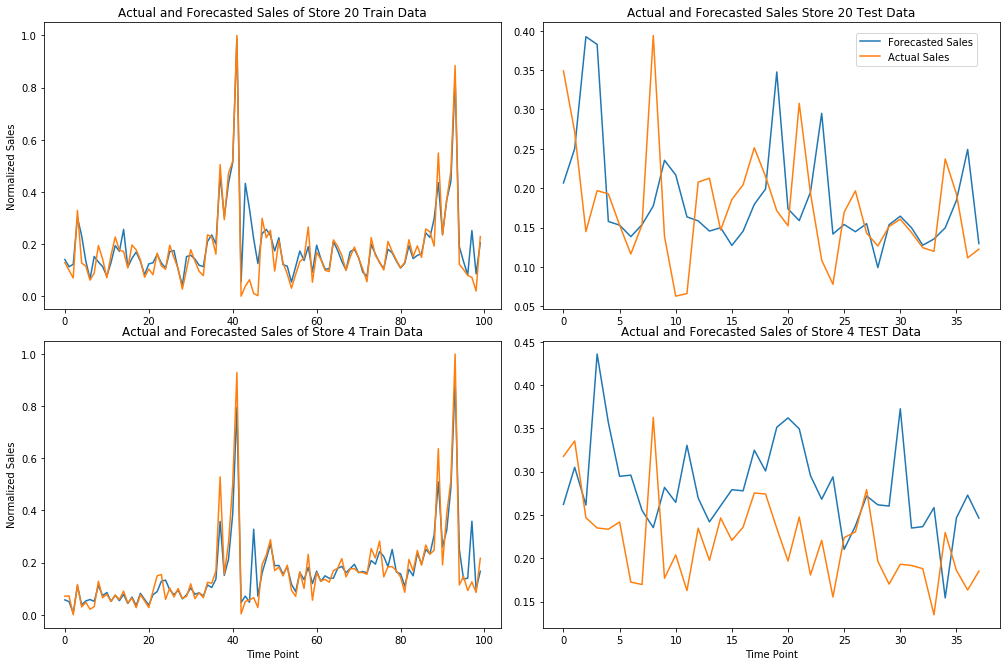

In [17]:
time_point_train = [el for el in range(0,100)]
time_point_test = [el for el in range(0,38)]

plt.rcParams["figure.figsize"] = [14,9]
fig, axs = plt.subplots(2, 2)
fig.tight_layout()

### STORE 20 TRAIN
axs[0, 0].plot(time_point_train, Y_pred_train_lst[19])
axs[0, 0].plot(time_point_train, list(stores_dict["store_20_train"]["Weekly_Sales_sum"]))
fig.legend(['Forecasted Sales', 'Actual Sales'], loc = (0.85, 0.9),ncol = 1)
axs[0, 0].set_title('Actual and Forecasted Sales of Store 20 Train Data')
axs[0, 0].set_ylabel('Normalized Sales')

### STORE 20 TEST
axs[0, 1].plot(time_point_test, Y_pred_test_lst[19])  ### 19th index in a list indexed from 0 to 44
axs[0, 1].plot(time_point_test, list(stores_dict["store_20_test"]["Weekly_Sales_sum"]))
axs[0, 1].set_title('Actual and Forecasted Sales Store 20 Test Data')


### STORE 4 TRAIN
axs[1, 0].plot(time_point_train, Y_pred_train_lst[3])
axs[1, 0].plot(time_point_train, list(stores_dict["store_4_train"]["Weekly_Sales_sum"]))
axs[1, 0].set_title('Actual and Forecasted Sales of Store 4 Train Data')
axs[1, 0].set_xlabel('Time Point')
axs[1, 0].set_ylabel('Normalized Sales')

### STORE 4 TEST
axs[1, 1].plot(time_point_test, Y_pred_test_lst[3])
axs[1, 1].plot(time_point_test, list(stores_dict["store_4_test"]["Weekly_Sales_sum"]))
axs[1, 1].set_title('Actual and Forecasted Sales of Store 4 TEST Data')
axs[1, 1].set_xlabel('Time Point')

plt.show()

### 1. B. Fitting RF Regression Model for each store on Train Data using only 'week_nbr_periodic', 'IsHoliday' & the lag attributes

In [18]:
mse_train2 = []
mse_test2 = []
Y_pred_train_lst2 = []
Y_pred_test_lst2 = []
for i in range(1,int(len(stores_dict)/2)+1):
    df_train = stores_dict["store_{}_train".format(i)]
    df_test = stores_dict["store_{}_test".format(i)]
    ### SPLITTING into X Train & X Test
    df_x_train = df_train[['IsHoliday','week_nbr_periodic','Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']]
    y_train = df_train['Weekly_Sales_sum']
    
    df_x_test = df_test[['IsHoliday','week_nbr_periodic','Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']]
    y_test = df_test['Weekly_Sales_sum']
    
    ### FIT the Linear Regression model
    reg = RandomForestRegressor().fit(df_x_train, y_train)
    
    ### Make Predictions on Train & Test data
    Y_pred_test = reg.predict(df_x_test)
    Y_pred_train = reg.predict(df_x_train)
    
    ### Append Predictions of each store into a list
    Y_pred_train_lst2.append(Y_pred_train)
    Y_pred_test_lst2.append(Y_pred_test)
    
    ### Append Train & Test MSE values of each store into a list
    mse_train2.append(mean_squared_error(y_train, Y_pred_train))
    mse_test2.append(mean_squared_error(y_test, Y_pred_test))

#### Average Test MSE across all 45 stores

In [19]:
sum(mse_test2)/len(mse_test2)

0.007868266074721787

#### Average Train MSE across all 45 stores

In [20]:
sum(mse_train2)/len(mse_train2)

0.0026445975673680634

#### Plotting Actual Vs Predicted Sales using RF Regression Approach 1B on Train & Test Data of Stores 20 and 4

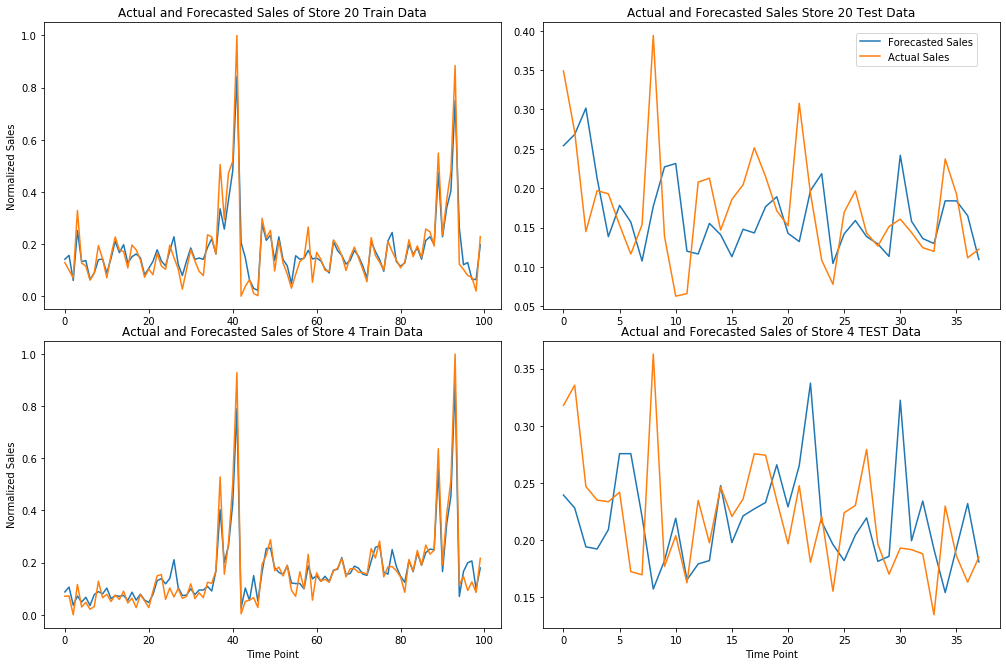

In [21]:
time_point_train = [el for el in range(0,100)]
time_point_test = [el for el in range(0,38)]

plt.rcParams["figure.figsize"] = [14,9]
fig, axs = plt.subplots(2, 2)
fig.tight_layout()

### STORE 20 TRAIN
axs[0, 0].plot(time_point_train, Y_pred_train_lst2[19])
axs[0, 0].plot(time_point_train, list(stores_dict["store_20_train"]["Weekly_Sales_sum"]))
fig.legend(['Forecasted Sales', 'Actual Sales'], loc = (0.85, 0.9),ncol = 1)
axs[0, 0].set_title('Actual and Forecasted Sales of Store 20 Train Data')
axs[0, 0].set_ylabel('Normalized Sales')

### STORE 20 TEST
axs[0, 1].plot(time_point_test, Y_pred_test_lst2[19])  ### 19th index in a list indexed from 0 to 44
axs[0, 1].plot(time_point_test, list(stores_dict["store_20_test"]["Weekly_Sales_sum"]))
axs[0, 1].set_title('Actual and Forecasted Sales Store 20 Test Data')


### STORE 4 TRAIN
axs[1, 0].plot(time_point_train, Y_pred_train_lst2[3])
axs[1, 0].plot(time_point_train, list(stores_dict["store_4_train"]["Weekly_Sales_sum"]))
axs[1, 0].set_title('Actual and Forecasted Sales of Store 4 Train Data')
axs[1, 0].set_xlabel('Time Point')
axs[1, 0].set_ylabel('Normalized Sales')

### STORE 4 TEST
axs[1, 1].plot(time_point_test, Y_pred_test_lst2[3])
axs[1, 1].plot(time_point_test, list(stores_dict["store_4_test"]["Weekly_Sales_sum"]))
axs[1, 1].set_title('Actual and Forecasted Sales of Store 4 TEST Data')
axs[1, 1].set_xlabel('Time Point')

plt.show()

#### Conclusion: We can observe that the random forest regression model built is not able to accurately forecast the seasonal drastic peaks and dips in sales in the test data but able to do it better on train data. But the random forest regressor is doing better than the linear regression model. For example the actual sales value for both stores 20 & store 4 are peaking to a very high value around the week of 20, while the model is not able to forecast the same peak in the test data. 

## APPROACH EXPERIMENT 2: Train One single RandomForest Regression Model

In the approach, the time series aspect is not taken into consideration and the moving window technique is not used. The characteristics of a store ('store type', 'store size'), other external characteristics ('Temperature','Fuel_Price','CPI','Unemployment','IsHoliday') along with week of the year ('week_nbr_periodic') columns are used as input attributes to make the predictions. This is implemented by treating the dataset as a regular function approximation problem data instead of a time series dataset (not using moving window lags & not training seperate model for every store). Hence a single RandomForest Regression model is trained on the entire dataset which is common for all the stores. 

In [22]:
store_lvl_df.head()

,Weekly_Sales_sum,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,week_nbr,Size,Type_A,Type_B,Type_C,week_nbr_periodic
0,1650399.00,1,2010-02-05,42.31,2.572,211.096358,8.106,False,1,151315,1,0,0,1
1,1675305.37,1,2010-02-12,38.51,2.548,211.242170,8.106,True,2,151315,1,0,0,2
2,1644421.11,1,2010-02-19,39.93,2.514,211.289143,8.106,False,3,151315,1,0,0,3
3,1442911.49,1,2010-02-26,46.63,2.561,211.319643,8.106,False,4,151315,1,0,0,4
4,1586448.75,1,2010-03-05,46.50,2.625,211.350143,8.106,False,5,151315,1,0,0,5


#### Creating Train & Test Split

In [23]:
store_lvl_df_train = store_lvl_df.iloc[:4500,]
store_lvl_df_test = store_lvl_df.iloc[4500:,]

In [24]:
%%capture
scaler = MinMaxScaler()
scaler = scaler.fit(store_lvl_df_train[['Weekly_Sales_sum','Temperature','Fuel_Price','CPI','Unemployment','Size']])
store_lvl_df_train[['Weekly_Sales_sum','Temperature','Fuel_Price','CPI','Unemployment','Size']] = scaler.transform(store_lvl_df_train[['Weekly_Sales_sum','Temperature','Fuel_Price','CPI','Unemployment','Size']])
store_lvl_df_test[['Weekly_Sales_sum','Temperature','Fuel_Price','CPI','Unemployment','Size']] = scaler.transform(store_lvl_df_test[['Weekly_Sales_sum','Temperature','Fuel_Price','CPI','Unemployment','Size']])

#### Training a single RF Regression Model

In [25]:
### SPLITTING into X Train & X Test
store_df_x_train = store_lvl_df_train[['Temperature','Fuel_Price','CPI','Unemployment','IsHoliday','week_nbr_periodic','Size',
                                      'Type_A', 'Type_B', 'Type_C']]
y_train = store_lvl_df_train['Weekly_Sales_sum']

store_df_x_test = store_lvl_df_test[['Temperature','Fuel_Price','CPI','Unemployment','IsHoliday','week_nbr_periodic','Size',
                                      'Type_A', 'Type_B', 'Type_C']]
y_test = store_lvl_df_test['Weekly_Sales_sum']

### FIT the Linear Regression model
reg = RandomForestRegressor().fit(store_df_x_train, y_train)

### Make Predictions on Train & Test data
Y_pred_test_lst3 = reg.predict(store_df_x_test)
Y_pred_train_lst3 = reg.predict(store_df_x_train)


### Calculate Train & Test MSE values of each store into a list
mse_train3 = mean_squared_error(y_train, Y_pred_train_lst3)
mse_test3 = mean_squared_error(y_test, Y_pred_test_lst3)

In [26]:
print("Training MSE of a single Linear Regression Model: ",mse_train3)
print("Testing MSE of a single Linear Regression Model: ",mse_test3)

Training MSE of a single Linear Regression Model:  0.00020652076427121274
Testing MSE of a single Linear Regression Model:  0.01806093733821128


*Appending Predicted Sales column to train & test DF*

In [27]:
cols = list(store_lvl_df_train.columns)
cols.append('Predicted_Sales')
### Appending predicted sales column to Train DF
store_lvl_df_train1 = pd.concat([store_lvl_df_train, pd.Series(Y_pred_train_lst3)], axis = 1)
store_lvl_df_train1.columns = cols

### Appending predicted sales column to Test DF
store_lvl_df_test1 = pd.concat([store_lvl_df_test.reset_index(), pd.Series(Y_pred_test_lst3)], axis = 1, ignore_index=True)
store_lvl_df_test1 = store_lvl_df_test1.drop(columns=[0])
store_lvl_df_test1.columns = cols

In [28]:
store_lvl_df_test1

,Weekly_Sales_sum,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,week_nbr,Size,Type_A,Type_B,Type_C,week_nbr_periodic,Predicted_Sales
0,0.252230,32,2011-05-20,0.438414,0.672467,0.659960,0.636269,False,68,0.910066,1,0,0,16,0.251150
1,0.260906,32,2011-05-27,0.537277,0.655578,0.660011,0.636269,False,69,0.910066,1,0,0,17,0.252087
2,0.259058,32,2011-06-03,0.601506,0.639202,0.660063,0.636269,False,70,0.910066,1,0,0,18,0.252087
3,0.280311,32,2011-06-10,0.646005,0.624872,0.660115,0.636269,False,71,0.910066,1,0,0,19,0.253775
4,0.266922,32,2011-06-17,0.665840,0.605425,0.660673,0.636269,False,72,0.910066,1,0,0,20,0.252693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,0.125541,45,2012-09-28,0.639603,0.758956,0.651876,0.649466,False,139,0.451136,0,1,0,35,0.197044
1931,0.130606,45,2012-10-05,0.639708,0.752815,0.653427,0.646945,False,140,0.451136,0,1,0,36,0.195028
1932,0.131224,45,2012-10-12,0.530350,0.760491,0.654977,0.646945,False,141,0.451136,0,1,0,37,0.204296
1933,0.125069,45,2012-10-19,0.551340,0.744626,0.655013,0.646945,False,142,0.451136,0,1,0,38,0.218918


#### Plotting Actual Vs Predicted Sales using RF Regression Approach 2 on Data of Stores 20, 4, 14 & 13

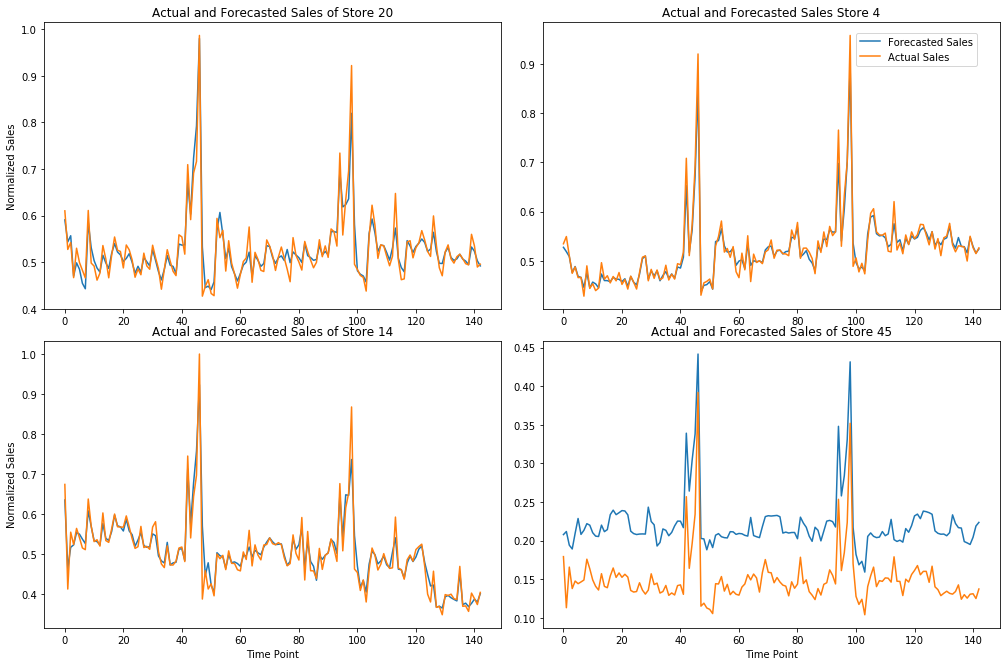

In [32]:
time_point_train = [el for el in range(0,143)]

plt.rcParams["figure.figsize"] = [14,9]
fig, axs = plt.subplots(2, 2)
fig.tight_layout()

### STORE 20 
axs[0, 0].plot(time_point_train, list(store_lvl_df_train1[store_lvl_df_train1['Store']==20].Predicted_Sales))
axs[0, 0].plot(time_point_train, list(store_lvl_df_train1[store_lvl_df_train1['Store']==20].Weekly_Sales_sum))
fig.legend(['Forecasted Sales', 'Actual Sales'], loc = (0.85, 0.9),ncol = 1)
axs[0, 0].set_title('Actual and Forecasted Sales of Store 20')
axs[0, 0].set_ylabel('Normalized Sales')

### STORE 4
axs[0, 1].plot(time_point_train, list(store_lvl_df_train1[store_lvl_df_train1['Store']==4].Predicted_Sales))  ### 19th index in a list indexed from 0 to 44
axs[0, 1].plot(time_point_train, list(store_lvl_df_train1[store_lvl_df_train1['Store']==4].Weekly_Sales_sum))
axs[0, 1].set_title('Actual and Forecasted Sales Store 4')


### STORE 4 TRAIN
axs[1, 0].plot(time_point_train, list(store_lvl_df_train1[store_lvl_df_train1['Store']==14].Predicted_Sales))
axs[1, 0].plot(time_point_train, list(store_lvl_df_train1[store_lvl_df_train1['Store']==14].Weekly_Sales_sum))
axs[1, 0].set_title('Actual and Forecasted Sales of Store 14')
axs[1, 0].set_xlabel('Time Point')
axs[1, 0].set_ylabel('Normalized Sales')

### STORE 4 TEST
axs[1, 1].plot(time_point_train, list(store_lvl_df_test1[store_lvl_df_test1['Store']==45].Predicted_Sales))
axs[1, 1].plot(time_point_train, list(store_lvl_df_test1[store_lvl_df_test1['Store']==45].Weekly_Sales_sum))
axs[1, 1].set_title('Actual and Forecasted Sales of Store 45')
axs[1, 1].set_xlabel('Time Point')

plt.show()

#### COMPARISON

In [33]:
Comparison_dict = {}
Comparison_dict['RF Regression Methods'] = ['45 models:Moving Window-all inputs','45 models:Moving Window-select inputs','1 model']
Comparison_dict['Train_MSE'] = [sum(mse_train)/len(mse_train),sum(mse_train2)/len(mse_train2),mse_train3]
Comparison_dict['Test_MSE'] = [sum(mse_test)/len(mse_test),sum(mse_test2)/len(mse_test2),mse_test3]
pd.DataFrame.from_dict(Comparison_dict)

,RF Regression Methods,Train_MSE,Test_MSE
0,45 models:Moving Window-all inputs,0.003377,0.008160
1,45 models:Moving Window-select inputs,0.002645,0.007868
2,1 model,0.000207,0.018061
